In [23]:
## BUSINESS USE CASE -- PLANE CRASHES HAPPEN!! HERE'S HOW YOU CAN AVOID DYING!!

In [24]:
import csv
import pickle
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

from __future__ import print_function, division

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
plt.rc('font', size=18) 

In [25]:
with open('airline_crash.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [26]:
state_df = pd.concat([df['Event_Id'], df['Location'].str.split(', ', expand=True)], axis=1)

In [27]:
state_df['City'] = state_df[0]
state_df['State'] = state_df[1]

state_df = state_df.drop([0,1,2,3,4],1)

In [28]:
df.reset_index(inplace=True)
state_df.reset_index(inplace=True)

In [29]:
df = pd.merge(df, state_df, on='index')

df = df.drop(['Location'],1)

In [30]:
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
df.Total_Fatal_Injuries = df.Total_Fatal_Injuries.astype('float')
df.Total_Serious_Injuries = df.Total_Serious_Injuries.astype('float')
df.Total_Minor_Injuries = df.Total_Minor_Injuries.astype('float')
df.Total_Uninjured = df.Total_Uninjured.astype('float')
df.Number_Engines = df.Number_Engines.astype('float')

df['Event_Date'] = pd.to_datetime(df['Event_Date'])

In [31]:
df.head()

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
0,0,20180719X01751,Accident,CEN18LA281,2018-07-19,United States,32.540277,-93.745000,DTN,Shreveport Executive,...,NaN,NaN,1.0,VMC,MANEUVERING,Preliminary,07/23/2018,20180719X01751,Shreveport,LA
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
2,2,20180717X82154,Accident,CEN18LA276,2018-07-17,United States,29.868056,-95.795000,IWS,West Houston,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/19/2018,20180717X82154,Katy,TX
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
4,4,20180716X60511,Accident,GAA18CA424,2018-07-16,United States,39.564722,-85.235555,N/A,NaN,...,NaN,1.0,NaN,NaN,NaN,Preliminary,07/19/2018,20180716X60511,New Castle,IN


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81899 entries, 0 to 81898
Data columns (total 34 columns):
index                     81899 non-null int64
Event_Id_x                81899 non-null object
Investigation_Type        81899 non-null object
Accident_Number           81899 non-null object
Event_Date                81899 non-null datetime64[ns]
Country                   81392 non-null object
Latitude                  28059 non-null float64
Longitude                 28050 non-null float64
Airport_Code              46449 non-null object
Airport_Name              51554 non-null object
Injury_Severity           81899 non-null object
Aircraft_Damage           79321 non-null object
Aircraft_Category         25157 non-null object
Registration_Number       78414 non-null object
Make                      81828 non-null object
Model                     81800 non-null object
Amateur_Built             81267 non-null object
Number_Engines            77419 non-null float64
Engine_Type      

In [33]:
df.Broad_Phase_of_Flight.value_counts()

LANDING        19925
TAKEOFF        15767
CRUISE         10911
MANEUVERING    10115
APPROACH        7940
TAXI            2401
CLIMB           2333
DESCENT         2264
GO-AROUND       1667
STANDING        1262
UNKNOWN          738
OTHER            164
Name: Broad_Phase_of_Flight, dtype: int64

In [34]:
df.Broad_Phase_of_Flight.replace('CRUISE', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('MANEUVERING', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('GO-AROUND', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('APPROACH', 'LANDING', inplace=True)
df.Broad_Phase_of_Flight.replace('DESCENT', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('CLIMB', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('STANDING', 'TAXI', inplace=True)

In [35]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
UNKNOWN       738
OTHER         164
Name: Broad_Phase_of_Flight, dtype: int64

In [36]:
df = df[df['Broad_Phase_of_Flight'] != 'OTHER']
df = df[df['Broad_Phase_of_Flight'] != 'UNKNOWN']

In [37]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
Name: Broad_Phase_of_Flight, dtype: int64

In [38]:
df = df.rename(columns={'Event_Id_x': 'Event_Id'})

df = df.drop(['Event_Id_y'], axis=1)

In [39]:
len(df.Aircraft_Category.unique())

13

In [40]:
real_df = df.dropna(subset=['Investigation_Type','Event_Date',
              'Country', 'Injury_Severity',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State'])

real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3689 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3689 non-null int64
Event_Id                  3689 non-null object
Investigation_Type        3689 non-null object
Accident_Number           3689 non-null object
Event_Date                3689 non-null datetime64[ns]
Country                   3689 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1801 non-null object
Airport_Name              2291 non-null object
Injury_Severity           3689 non-null object
Aircraft_Damage           3636 non-null object
Aircraft_Category         3689 non-null object
Registration_Number       3689 non-null object
Make                      3683 non-null object
Model                     3675 non-null object
Amateur_Built             3689 non-null object
Number_Engines            3689 non-null float64
Engine_Type               3689 non

In [41]:
real_df.Aircraft_Category.value_counts()

Airplane      3270
Helicopter     318
Glider          52
Balloon         30
Gyrocraft       17
Ultralight       1
Unknown          1
Name: Aircraft_Category, dtype: int64

In [42]:
real_df.Weather_Condition.value_counts()

VMC    3309
IMC     329
UNK      51
Name: Weather_Condition, dtype: int64

In [43]:
real_df = real_df[real_df['Weather_Condition'] != 'UNK']

In [44]:
real_df = real_df[real_df['Aircraft_Category'] != 'Ultralight']
real_df = real_df[real_df['Aircraft_Category'] != 'Unknown']

In [45]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3636 non-null int64
Event_Id                  3636 non-null object
Investigation_Type        3636 non-null object
Accident_Number           3636 non-null object
Event_Date                3636 non-null datetime64[ns]
Country                   3636 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1786 non-null object
Airport_Name              2276 non-null object
Injury_Severity           3636 non-null object
Aircraft_Damage           3585 non-null object
Aircraft_Category         3636 non-null object
Registration_Number       3636 non-null object
Make                      3630 non-null object
Model                     3622 non-null object
Amateur_Built             3636 non-null object
Number_Engines            3636 non-null float64
Engine_Type               3636 non

In [46]:
not_plane = real_df[real_df['Aircraft_Category'] != 'Airplane']

In [47]:
not_plane.Broad_Phase_of_Flight.value_counts()

INFLIGHT    212
LANDING     119
TAKEOFF      71
TAXI         13
Name: Broad_Phase_of_Flight, dtype: int64

In [48]:
real_df = real_df[['Event_Id','Investigation_Type','Event_Date',
              'Country', 'Injury_Severity',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State']]

In [49]:
real_df.State.value_counts()

CA         402
TX         314
AK         202
FL         201
AZ         122
CO         103
WA         103
IL         100
PA          96
NY          92
MO          90
OH          86
MI          86
GA          85
OR          83
LA          78
NM          70
AR          68
OK          67
MN          67
NC          66
AL          62
KS          60
IN          55
MT          55
IA          53
ID          52
WI          51
SC          49
UT          47
NJ          47
NV          47
KY          46
WY          46
VA          45
NE          42
MA          34
MS          34
TN          32
ND          31
MD          28
CT          22
ME          21
WV          19
NH          19
SD          18
HI          12
VT           9
RI           7
DE           4
DC           4
Bahamas      3
PR           1
Name: State, dtype: int64

In [50]:
real_df['Total_Passengers'] = (real_df['Total_Fatal_Injuries'] + real_df['Total_Serious_Injuries'] + 
                                real_df['Total_Minor_Injuries'] + real_df['Total_Uninjured'])

In [51]:
real_df['Total_Passengers'].value_counts()

1.0      1576
2.0      1150
3.0       404
4.0       286
5.0        80
6.0        38
7.0        25
8.0        14
10.0        5
12.0        5
11.0        4
20.0        4
9.0         4
68.0        3
15.0        2
51.0        2
57.0        2
21.0        2
18.0        2
58.0        1
22.0        1
116.0       1
23.0        1
136.0       1
130.0       1
168.0       1
119.0       1
212.0       1
39.0        1
102.0       1
138.0       1
33.0        1
65.0        1
393.0       1
155.0       1
146.0       1
129.0       1
73.0        1
217.0       1
16.0        1
30.0        1
108.0       1
152.0       1
48.0        1
29.0        1
13.0        1
84.0        1
Name: Total_Passengers, dtype: int64

In [52]:
def solo_flight(row):
    if row['Total_Passengers'] == 1 :
        return 'Yes'
    else:
        return 'No'

In [53]:
real_df.apply(lambda row: solo_flight(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369    Yes
16370     No
16395    Yes
16412     No
16418     No
16438    Yes
16472     No
16480    Yes
16507    Yes
16540     No
16546     No
16569    Yes
16571     No
16592    Yes
16600    Yes
16621     No
16667    Yes
16674     No
16733    Yes
16802     No
16850     No
16851     No
16857     No
16862    Yes
16895     No
16911     No
        ... 
81857     No
81858     No
81859    Yes
81860    Yes
81861     No
81862     No
81864     No
81865     No
81866     No
81867     No
81868     No
81869    Yes
81870     No
81871     No
81872     No
81873    Yes
81874     No
81875    Yes
81876    Yes
81877     No
81878    Yes
81879    Yes
81880    Yes
81881     No
81882    Yes
81883    Yes
81884     No
81885    Yes
81887     No
81888     No
Length: 3636, dtype: object

In [54]:
real_df['Solo_Flight'] = real_df.apply(lambda row: solo_flight(row),axis=1)

In [55]:
real_df['Solo_Flight'].value_counts()

No     2060
Yes    1576
Name: Solo_Flight, dtype: int64

In [56]:
real_df['Flight_Purpose'].value_counts()

Personal                     1985
Unknown                       582
Instructional                 420
Business                      295
Aerial Application            166
Ferry                          70
Executive/Corporate            52
Positioning                    23
Aerial Observation             13
Public Aircraft                 8
Flight Test                     6
External Load                   3
Air Race/Show                   3
Skydiving                       3
Other Work Use                  2
Public Aircraft - Local         2
Glider Tow                      1
Public Aircraft - Federal       1
Public Aircraft - State         1
Name: Flight_Purpose, dtype: int64

In [57]:
real_df.Flight_Purpose.replace('Unknown', 'Other', inplace=True)
real_df.Flight_Purpose.replace('Executive/Corporate', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Aerial Observation', 'Aerial Application', inplace=True)
real_df.Flight_Purpose.replace('Flight Test', 'Instructional', inplace=True)
real_df.Flight_Purpose.replace('Air Race/Show', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Skydiving', 'Business', inplace=True)
real_df.Flight_Purpose.replace('External Load', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Local', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Other Work Use', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Federal', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Glider Tow', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - State', 'Business', inplace=True)

In [58]:
real_df['Flight_Purpose'].value_counts()

Personal              1985
Other                  582
Instructional          426
Business               371
Aerial Application     179
Ferry                   70
Positioning             23
Name: Flight_Purpose, dtype: int64

In [59]:
real_df['Was_Fatal'] = real_df['Total_Fatal_Injuries']

fatal = np.array(real_df['Was_Fatal'].values.tolist())

In [60]:
real_df['Was_Fatal'] = np.where(fatal > 0, 'Fatal', fatal).tolist()

In [61]:
new_fatal = np.array(real_df['Was_Fatal'].values.tolist())

new_fatal

array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'], dtype='<U5')

In [62]:
real_df['Was_Fatal'] = np.where(new_fatal == '0.0', 'Non-fatal', new_fatal).tolist()

In [63]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Solo_Flight,Was_Fatal
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,1.0,1.0,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,Non-fatal
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Instructional,...,0.0,0.0,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,Non-fatal
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Airplane,Yes,1.0,Reciprocating,Personal,...,2.0,0.0,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,Non-fatal
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,0.0,0.0,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Non-fatal
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Helicopter,No,1.0,Turbo Shaft,Business,...,1.0,0.0,0.0,VMC,INFLIGHT,Cougar,WA,1.0,Yes,Non-fatal


In [64]:
real_df['Was_Fatal'].value_counts()

Non-fatal    2975
Fatal         661
Name: Was_Fatal, dtype: int64

In [65]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 16185 to 81888
Data columns (total 21 columns):
Event_Id                  3636 non-null object
Investigation_Type        3636 non-null object
Event_Date                3636 non-null datetime64[ns]
Country                   3636 non-null object
Injury_Severity           3636 non-null object
Aircraft_Category         3636 non-null object
Amateur_Built             3636 non-null object
Number_Engines            3636 non-null float64
Engine_Type               3636 non-null object
Flight_Purpose            3636 non-null object
Total_Fatal_Injuries      3636 non-null float64
Total_Serious_Injuries    3636 non-null float64
Total_Minor_Injuries      3636 non-null float64
Total_Uninjured           3636 non-null float64
Weather_Condition         3636 non-null object
Broad_Phase_of_Flight     3636 non-null object
City                      3636 non-null object
State                     3636 non-null object
Total_Passengers          363

In [66]:
real_df['Month'] = real_df['Event_Date'].dt.month

In [67]:
real_df.Month.value_counts()

7     435
8     405
5     394
6     357
9     343
4     324
3     275
10    242
11    233
2     223
12    209
1     196
Name: Month, dtype: int64

In [68]:
real_df['Season'] = ((real_df['Month']%12 + 3)//3)

real_df.Season.value_counts()

3    1197
2     993
4     818
1     628
Name: Season, dtype: int64

In [69]:
real_df.Season.replace(1, 'Winter', inplace=True)
real_df.Season.replace(2, 'Spring', inplace=True)
real_df.Season.replace(3, 'Summer', inplace=True)
real_df.Season.replace(4, 'Fall', inplace=True)

In [70]:
real_df.Season.value_counts()

Summer    1197
Spring     993
Fall       818
Winter     628
Name: Season, dtype: int64

In [71]:
fatal_crash_df = real_df[real_df['Was_Fatal'] == 'Fatal']

In [72]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 16185 to 81888
Data columns (total 23 columns):
Event_Id                  3636 non-null object
Investigation_Type        3636 non-null object
Event_Date                3636 non-null datetime64[ns]
Country                   3636 non-null object
Injury_Severity           3636 non-null object
Aircraft_Category         3636 non-null object
Amateur_Built             3636 non-null object
Number_Engines            3636 non-null float64
Engine_Type               3636 non-null object
Flight_Purpose            3636 non-null object
Total_Fatal_Injuries      3636 non-null float64
Total_Serious_Injuries    3636 non-null float64
Total_Minor_Injuries      3636 non-null float64
Total_Uninjured           3636 non-null float64
Weather_Condition         3636 non-null object
Broad_Phase_of_Flight     3636 non-null object
City                      3636 non-null object
State                     3636 non-null object
Total_Passengers          363

In [73]:
relative_season_impact = pd.value_counts(fatal_crash_df['Season']) / pd.value_counts(real_df['Season'])

Text(0.5,1,'Fatal Accidents by Season')

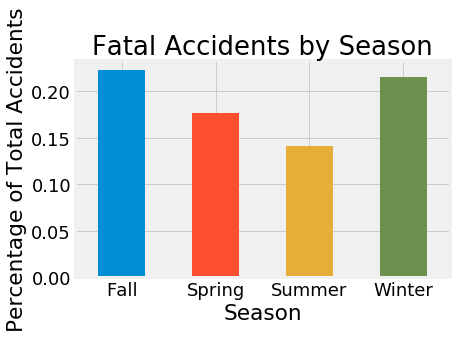

In [74]:
relative_season_impact.plot.bar()
plt.xlabel('Season')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Season")

## Fall and winter have the relatively highest fatal accidents!

In [75]:
amatuer_build_impact = pd.value_counts(fatal_crash_df['Amateur_Built']) / pd.value_counts(real_df['Amateur_Built'])

Text(0.5,1,'Fatal Accidents by Amatuer Built')

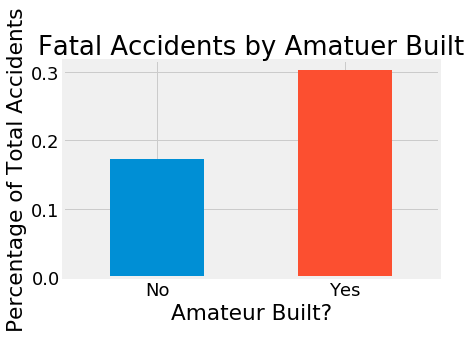

In [76]:
amatuer_build_impact.plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Amatuer Built")

In [77]:
flight_purpose_impact = pd.value_counts(fatal_crash_df['Flight_Purpose']) / pd.value_counts(real_df['Flight_Purpose'])

Text(0.5,1,'Fatal Accidents by Flight Purpose')

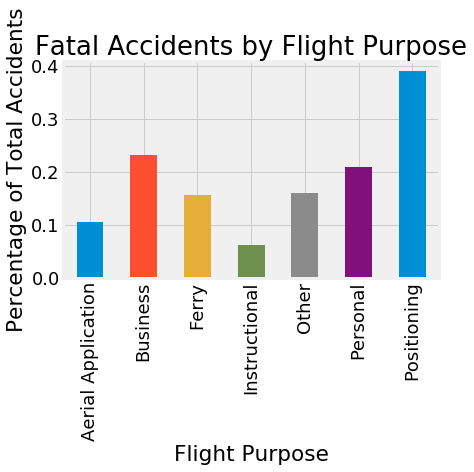

In [78]:
flight_purpose_impact.plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Flight Purpose")

In [79]:
weather_impact = pd.value_counts(fatal_crash_df['Weather_Condition']) / pd.value_counts(real_df['Weather_Condition'])

Text(0.5,1,'Fatal Accidents by Weather Condition')

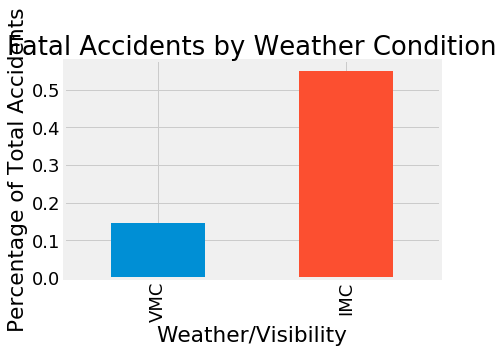

In [80]:
weather_impact.plot.bar()
plt.xlabel('Weather/Visibility')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Weather Condition")

In [81]:
flight_phase_impact = pd.value_counts(fatal_crash_df['Broad_Phase_of_Flight']) / pd.value_counts(real_df['Broad_Phase_of_Flight'])

Text(0.5,1,'Fatal Accidents by flight phase')

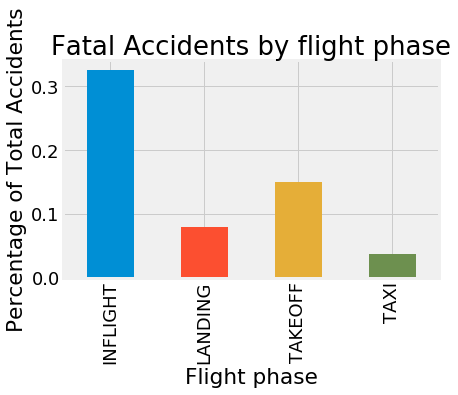

In [82]:
flight_phase_impact.plot.bar()
plt.xlabel('Flight phase')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by flight phase")

In [83]:
aircraft_category_impact = pd.value_counts(fatal_crash_df['Aircraft_Category']) / pd.value_counts(real_df['Aircraft_Category'])

Text(0.5,1,'Fatal Accidents by aircraft category')

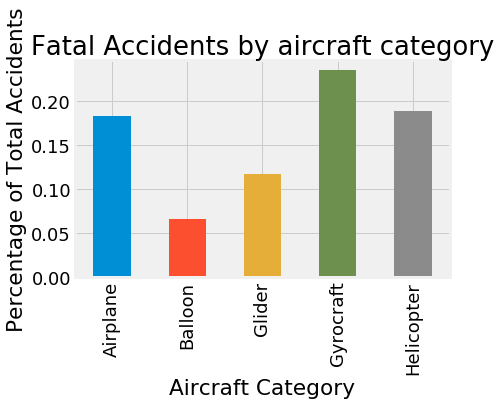

In [84]:
aircraft_category_impact.plot.bar()
plt.xlabel('Aircraft Category')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by aircraft category")

In [85]:
solo_flight_impact = pd.value_counts(fatal_crash_df['Solo_Flight']) / pd.value_counts(real_df['Solo_Flight'])

Text(0.5,1,'Fatal Accidents by solo flight')

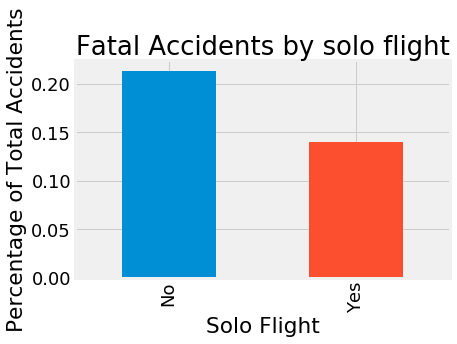

In [86]:
solo_flight_impact.plot.bar()
plt.xlabel('Solo Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by solo flight")

In [87]:
engine_type_impact = pd.value_counts(fatal_crash_df['Engine_Type']) / pd.value_counts(real_df['Engine_Type'])

Text(0.5,1,'Fatal Accidents by engine type')

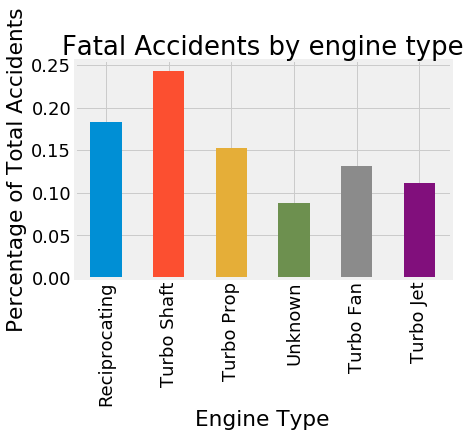

In [88]:
engine_type_impact.plot.bar()
plt.xlabel('Engine Type')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by engine type")

In [89]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 16185 to 81888
Data columns (total 23 columns):
Event_Id                  3636 non-null object
Investigation_Type        3636 non-null object
Event_Date                3636 non-null datetime64[ns]
Country                   3636 non-null object
Injury_Severity           3636 non-null object
Aircraft_Category         3636 non-null object
Amateur_Built             3636 non-null object
Number_Engines            3636 non-null float64
Engine_Type               3636 non-null object
Flight_Purpose            3636 non-null object
Total_Fatal_Injuries      3636 non-null float64
Total_Serious_Injuries    3636 non-null float64
Total_Minor_Injuries      3636 non-null float64
Total_Uninjured           3636 non-null float64
Weather_Condition         3636 non-null object
Broad_Phase_of_Flight     3636 non-null object
City                      3636 non-null object
State                     3636 non-null object
Total_Passengers          363

In [90]:
dummy_df = real_df[['Season', 'Aircraft_Category', 'Amateur_Built', 'Engine_Type',
                    'Flight_Purpose', 'Weather_Condition', 'Broad_Phase_of_Flight', 'Solo_Flight']]

In [91]:
dummy_df = pd.get_dummies(dummy_df)

In [92]:
# dummy_df.reset_index(inplace=True)
# real_df.reset_index(inplace=True)

In [93]:
dummy_df.head()

,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,Aircraft_Category_Helicopter,Amateur_Built_No,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
16185,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
16254,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
16315,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0
16337,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,1
16369,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,1


In [94]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Solo_Flight,Was_Fatal,Month,Season
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,Non-fatal,11,Fall
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Instructional,...,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,Non-fatal,11,Fall
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Airplane,Yes,1.0,Reciprocating,Personal,...,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,Non-fatal,10,Fall
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Non-fatal,10,Fall
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Helicopter,No,1.0,Turbo Shaft,Business,...,0.0,VMC,INFLIGHT,Cougar,WA,1.0,Yes,Non-fatal,10,Fall


In [95]:
real_df = real_df.join(dummy_df)

In [96]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,Flight_Purpose,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,1,0,0,1,1,0,0,0,1,0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Instructional,...,0,0,0,1,0,0,1,0,1,0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,Airplane,Yes,1.0,Reciprocating,Personal,...,1,0,0,1,1,0,0,0,1,0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,Airplane,No,1.0,Reciprocating,Personal,...,1,0,0,1,0,1,0,0,0,1
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,Helicopter,No,1.0,Turbo Shaft,Business,...,0,0,0,1,1,0,0,0,0,1


In [97]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 16185 to 81888
Data columns (total 55 columns):
Event_Id                             3636 non-null object
Investigation_Type                   3636 non-null object
Event_Date                           3636 non-null datetime64[ns]
Country                              3636 non-null object
Injury_Severity                      3636 non-null object
Aircraft_Category                    3636 non-null object
Amateur_Built                        3636 non-null object
Number_Engines                       3636 non-null float64
Engine_Type                          3636 non-null object
Flight_Purpose                       3636 non-null object
Total_Fatal_Injuries                 3636 non-null float64
Total_Serious_Injuries               3636 non-null float64
Total_Minor_Injuries                 3636 non-null float64
Total_Uninjured                      3636 non-null float64
Weather_Condition                    3636 non-null object
Broad

In [98]:
real_df.columns

Index(['Event_Id', 'Investigation_Type', 'Event_Date', 'Country',
       'Injury_Severity', 'Aircraft_Category', 'Amateur_Built',
       'Number_Engines', 'Engine_Type', 'Flight_Purpose',
       'Total_Fatal_Injuries', 'Total_Serious_Injuries',
       'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition',
       'Broad_Phase_of_Flight', 'City', 'State', 'Total_Passengers',
       'Solo_Flight', 'Was_Fatal', 'Month', 'Season', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry'

In [99]:
target_count = real_df['Was_Fatal'].value_counts()
print(f'Non-Fatal: {target_count[0]}')
print(f'Fatal: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Non-Fatal: 2975
Fatal: 661
Proportion: 4.5 : 1
Percentage of Majority Class: 81.82000000000001


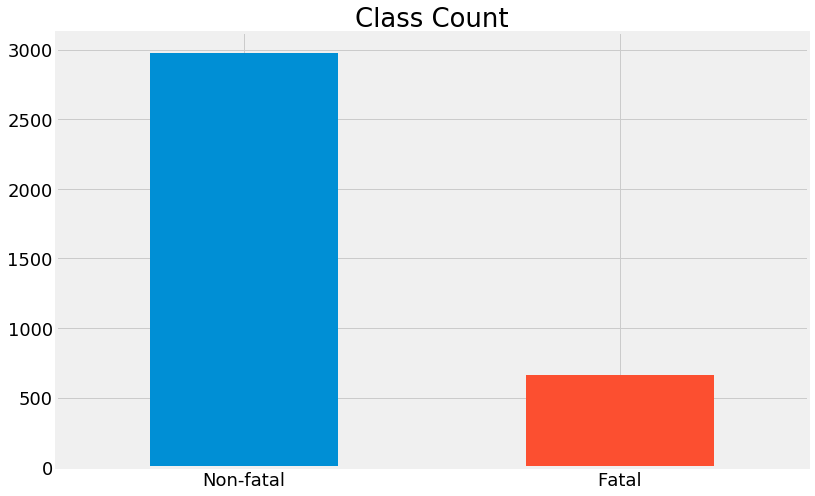

In [100]:
target_count.plot(kind='bar', title='Class Count', rot=0);
plt.gcf().set_size_inches(12,8)

In [101]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

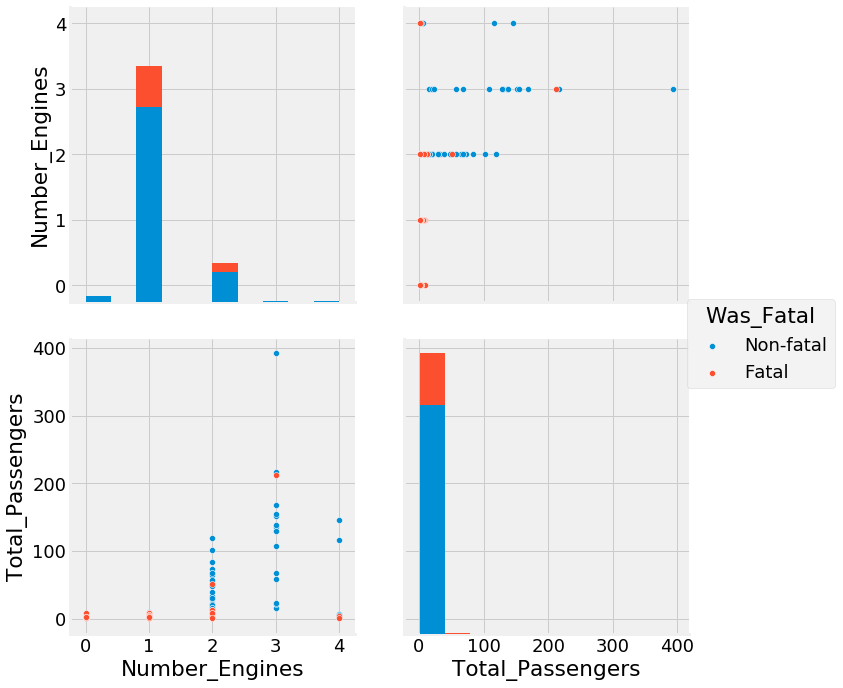

In [102]:
numerical_df = real_df[['Number_Engines','Total_Passengers','Was_Fatal']]

sns.pairplot(numerical_df, hue='Was_Fatal', size=5);

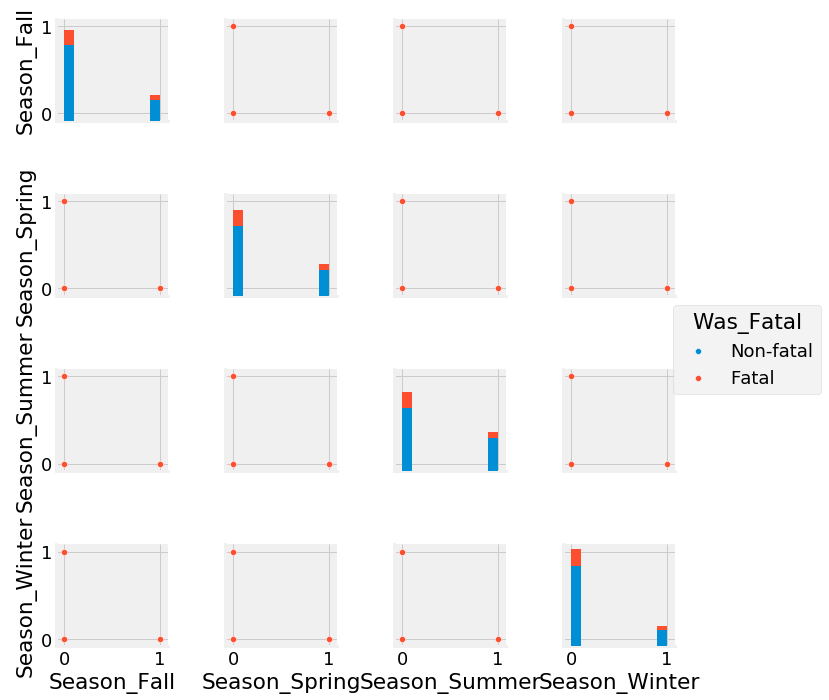

In [103]:
season_df = real_df[['Was_Fatal','Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter']]

sns.pairplot(season_df, hue='Was_Fatal');

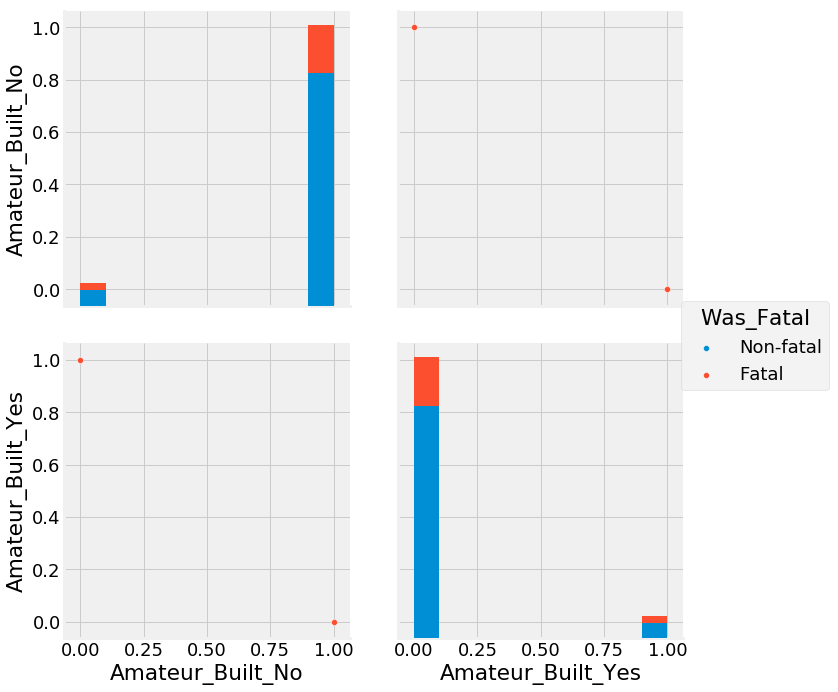

In [104]:
amateur_df = real_df[['Was_Fatal','Amateur_Built_No', 'Amateur_Built_Yes']]

sns.pairplot(amateur_df, hue='Was_Fatal', size=5);

# END OF EDA / START OF ANALYSIS

In [368]:
y = real_df['Was_Fatal']
X = real_df[['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [369]:
X_train.head()

,Number_Engines,Total_Passengers,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
81228,2.0,1.0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
78990,1.0,4.0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
80681,1.0,1.0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
80265,0.0,3.0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
78806,1.0,2.0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0


In [370]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Number_Engines','Total_Passengers'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Number_Engines','Total_Passengers'],1)

X_train = X_train.set_index('index')

X_test_scalable = X_FINALtest.filter(['Number_Engines','Total_Passengers'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_FINALtest.reset_index(inplace=True)
X_FINALtest = X_FINALtest.join(X_test_scaled_columns)
X_FINALtest = X_FINALtest.drop(['Number_Engines','Total_Passengers'],1)

X_FINALtest = X_FINALtest.set_index('index')

In [371]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 34 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Aircraft_Category_Airplane           2727 non-null uint8
Aircraft_Category_Balloon            2727 non-null uint8
Aircraft_Category_Glider             2727 non-null uint8
Aircraft_Category_Gyrocraft          2727 non-null uint8
Aircraft_Category_Helicopter         2727 non-null uint8
Amateur_Built_No                     2727 non-null uint8
Amateur_Built_Yes                    2727 non-null uint8
Engine_Type_Reciprocating            2727 non-null uint8
Engine_Type_Turbo Fan                2727 non-null uint8
Engine_Type_Turbo Jet                2727 non-null uint8
Engine_Type_Turbo Prop               2727 non-null uint8
Engine_Type_Turbo Shaft          

In [372]:
X_FINALtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 909 entries, 80468 to 78807
Data columns (total 34 columns):
Season_Fall                          909 non-null uint8
Season_Spring                        909 non-null uint8
Season_Summer                        909 non-null uint8
Season_Winter                        909 non-null uint8
Aircraft_Category_Airplane           909 non-null uint8
Aircraft_Category_Balloon            909 non-null uint8
Aircraft_Category_Glider             909 non-null uint8
Aircraft_Category_Gyrocraft          909 non-null uint8
Aircraft_Category_Helicopter         909 non-null uint8
Amateur_Built_No                     909 non-null uint8
Amateur_Built_Yes                    909 non-null uint8
Engine_Type_Reciprocating            909 non-null uint8
Engine_Type_Turbo Fan                909 non-null uint8
Engine_Type_Turbo Jet                909 non-null uint8
Engine_Type_Turbo Prop               909 non-null uint8
Engine_Type_Turbo Shaft              909 non-null

In [373]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    y_predict = models[i].predict(X_temptest)
    accuracy = np.round(accuracy_score(y_temptest, y_predict), 4)
    precision = np.round(precision_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    recall = np.round(recall_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    f1 = np.round(f1_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    print(f'{names[i]} acc: {accuracy} prec: {precision} recall: {recall} f1-score: {f1}')
    print('')

LR acc: 0.8425 prec: 0.5818 recall: 0.2319 f1-score: 0.3316

KNN acc: 0.8278 prec: 0.4789 recall: 0.2464 f1-score: 0.3254

NB acc: 0.7668 prec: 0.3732 recall: 0.5652 f1-score: 0.4496

SVC acc: 0.8413 prec: 0.5588 recall: 0.2754 f1-score: 0.3689

Decision Tree acc: 0.7814 prec: 0.3306 recall: 0.2899 f1-score: 0.3089

Random Forest acc: 0.7998 prec: 0.3415 recall: 0.2029 f1-score: 0.2545

Gradient Boosted Trees acc: 0.8462 prec: 0.5909 recall: 0.2826 f1-score: 0.3824



In [374]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.8247158049138247, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
logistic: best score: 0.8346167950128346, best estimator: LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.8291162449578291, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.8335166850018335, bes

In [375]:
from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

def feature_selection(X, y, count):

    # Feature Importance from Random Forest
    ET = ExtraTreesClassifier()
    ET.fit(X, y)    
    importances = list(zip(ET.feature_importances_, X.columns))
    importances.sort(reverse=True)
    FI_features = [x[1] for x in importances][0:count]

    # Recursive Feature Elimination
    lm1 = LogisticRegression()
    rfe = RFE(lm1, count)
    fit = rfe.fit(X, y)
    RFE_features = list(X.columns[fit.support_])

    # PCA
#     pca = PCA(n_components=5)
#     fit = pca.fit(X)    
#     df = pd.DataFrame(pca.components_,columns=X.columns).abs().mean().sort_values(ascending = False)
#     PCA_features = list(df.index.values)[0:7]
    
    feats = pd.DataFrame(
        {
         'Feature_Importance': FI_features,
         'RFE': RFE_features,
#          'PCA': PCA_features
        })
    
    return feats

In [376]:
feature_selection(X_train, y_train, 20)

,Feature_Importance,RFE
0,Total_Passengers_Scaled,Season_Summer
1,Weather_Condition_VMC,Aircraft_Category_Helicopter
2,Broad_Phase_of_Flight_INFLIGHT,Amateur_Built_No
3,Number_Engines_Scaled,Amateur_Built_Yes
4,Weather_Condition_IMC,Engine_Type_Reciprocating
5,Broad_Phase_of_Flight_LANDING,Engine_Type_Turbo Fan
6,Flight_Purpose_Personal,Engine_Type_Turbo Prop
7,Flight_Purpose_Other,Engine_Type_Turbo Shaft
8,Season_Summer,Engine_Type_Unknown
9,Season_Spring,Flight_Purpose_Aerial Application


In [377]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.8346167950128346, best estimator: LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [378]:
lm1 = grid.best_estimator_
lm1.fit(X_train, y_train)

LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [379]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- Logistic Regress MVP')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- Logistic Regress MVP
Logistic Regress accuracy: 0.8335 precision: 0.628 recall: 0.2103 f1: 0.3144 fB: 0.2424



In [380]:
columns = ['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm1.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane           0.027113
Aircraft_Category_Balloon            0.196349
Aircraft_Category_Glider             0.142733
Aircraft_Category_Gyrocraft          0.571198
Aircraft_Category_Helicopter        -0.199186
Amateur_Built_No                    -0.246682
Amateur_Built_Yes                    0.206077
Broad_Phase_of_Flight_INFLIGHT      -0.149821
Broad_Phase_of_Flight_LANDING        0.638868
Broad_Phase_of_Flight_TAKEOFF       -0.117868
Broad_Phase_of_Flight_TAXI           0.489879
Engine_Type_Reciprocating            0.288537
Engine_Type_Turbo Fan                0.355335
Engine_Type_Turbo Jet               -0.300396
Engine_Type_Turbo Prop               0.069141
Engine_Type_Turbo Shaft              0.491260
Engine_Type_Unknown                 -0.066162
Flight_Purpose_Aerial Application   -0.120253
Flight_Purpose_Business              0.407276
Flight_Purpose_Ferry                 0.322874
Flight_Purpose_Instructional        -0.217031
Flight_Purpose_Other              

In [381]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.8331499816648331, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [382]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [383]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- RF MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- RF MVP
RF MVP accuracy: 0.8354 precision: 0.6792 recall: 0.1768 f1: 0.2805 fB: 0.2075



In [384]:
columns = ['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.000272
Aircraft_Category_Balloon            0.000116
Aircraft_Category_Glider             0.003270
Aircraft_Category_Gyrocraft          0.017868
Aircraft_Category_Helicopter         0.015606
Amateur_Built_No                     0.006102
Amateur_Built_Yes                    0.001168
Broad_Phase_of_Flight_INFLIGHT       0.013725
Broad_Phase_of_Flight_LANDING        0.009950
Broad_Phase_of_Flight_TAKEOFF        0.023594
Broad_Phase_of_Flight_TAXI           0.012453
Engine_Type_Reciprocating            0.000000
Engine_Type_Turbo Fan                0.002197
Engine_Type_Turbo Jet                0.001909
Engine_Type_Turbo Prop               0.001086
Engine_Type_Turbo Shaft              0.014296
Engine_Type_Unknown                  0.008813
Flight_Purpose_Aerial Application    0.000452
Flight_Purpose_Business              0.013049
Flight_Purpose_Ferry                 0.011467
Flight_Purpose_Instructional         0.014512
Flight_Purpose_Other              

In [385]:
beta = np.linspace(1, 2, 10)

param_grid = dict(beta=beta)
print(param_grid)

{'beta': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ])}


In [386]:
from sklearn.metrics import fbeta_score

for b in beta:
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = rf.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'TEST Scores with unbalanced RF -- beta: {b}')
    print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

TEST Scores with unbalanced RF -- beta: 1.0
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2871

TEST Scores with unbalanced RF -- beta: 1.1111111111111112
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2706

TEST Scores with unbalanced RF -- beta: 1.2222222222222223
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2576

TEST Scores with unbalanced RF -- beta: 1.3333333333333333
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.247

TEST Scores with unbalanced RF -- beta: 1.4444444444444444
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2385

TEST Scores with unbalanced RF -- beta: 1.5555555555555556
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2315

TEST Scores with unbalanced RF -- beta: 1.6666666666666665
accuracy: 0.8361 precision: 0.6818 recall: 0.1818 f1: 0.2871 fB: 0.2256

TEST Scores with unbalanced RF -- beta: 1.7777777777777777
accuracy: 0.8361 precision: 0.681

## MVP WITH SMOTE

In [387]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [388]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling
LR accuracy: 0.5163 precision: 0.5927 recall: 0.6553 f1: 0.4955 fB: 0.5547

Scores with SMOTE Oversampling
KNN accuracy: 0.6297 precision: 0.6286 recall: 0.638 f1: 0.5731 fB: 0.5962

Scores with SMOTE Oversampling
NB accuracy: 0.5895 precision: 0.534 recall: 0.8719 f1: 0.6 fB: 0.7053

Scores with SMOTE Oversampling
SVC accuracy: 0.483 precision: 0.5811 recall: 0.6577 f1: 0.47 fB: 0.5403

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.7129 precision: 0.6398 recall: 0.7282 f1: 0.6464 fB: 0.6829

Scores with SMOTE Oversampling
Random Forest accuracy: 0.7176 precision: 0.6553 recall: 0.733 f1: 0.6561 fB: 0.6902

Scores with SMOTE Oversampling
Gradient Boosted Trees accuracy: 0.7055 precision: 0.6731 recall: 0.7026 f1: 0.6477 fB: 0.6694



In [389]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7920215150156881, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [390]:
rf2 = grid.best_estimator_
rf2.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [391]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED MVP
RF MVP accuracy: 0.8279 precision: 0.6949 recall: 0.7963 f1: 0.7315 fB: 0.7657



In [392]:
feature_selection(X_smoted, y_smoted, 20)

,Feature_Importance,RFE
0,Weather_Condition_IMC,Aircraft_Category_Gyrocraft
1,Solo_Flight_Yes,Aircraft_Category_Helicopter
2,Weather_Condition_VMC,Amateur_Built_No
3,Flight_Purpose_Positioning,Amateur_Built_Yes
4,Flight_Purpose_Instructional,Engine_Type_Reciprocating
5,Flight_Purpose_Personal,Engine_Type_Turbo Jet
6,Solo_Flight_No,Engine_Type_Turbo Prop
7,Total_Passengers,Engine_Type_Turbo Shaft
8,Season_Fall,Engine_Type_Unknown
9,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Business


In [393]:
columns = ['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf2.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.001591
Aircraft_Category_Balloon            0.001558
Aircraft_Category_Glider             0.010630
Aircraft_Category_Gyrocraft          0.011891
Aircraft_Category_Helicopter         0.018283
Amateur_Built_No                     0.013754
Amateur_Built_Yes                    0.002082
Broad_Phase_of_Flight_INFLIGHT       0.040027
Broad_Phase_of_Flight_LANDING        0.019073
Broad_Phase_of_Flight_TAKEOFF        0.012098
Broad_Phase_of_Flight_TAXI           0.027037
Engine_Type_Reciprocating            0.000523
Engine_Type_Turbo Fan                0.004314
Engine_Type_Turbo Jet                0.003323
Engine_Type_Turbo Prop               0.002262
Engine_Type_Turbo Shaft              0.028612
Engine_Type_Unknown                  0.017537
Flight_Purpose_Aerial Application    0.005080
Flight_Purpose_Business              0.039608
Flight_Purpose_Ferry                 0.028932
Flight_Purpose_Instructional         0.059158
Flight_Purpose_Other              

In [394]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

# models = [('knn', KNeighborsClassifier), 
#           ('logistic', LogisticRegression),
#           ('tree', DecisionTreeClassifier),
#           ('forest', RandomForestClassifier)
#          ]

# param_choices = [
#     {
#         'n_neighbors': range(1, 12)
#     },
#     {
#         'C': np.logspace(-3,6, 12),
#         'penalty': ['l1', 'l2']
#     },
#     {
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     },
#     {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     }
# ]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(), params)
#     grid.fit(X_smoted, y_smoted)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [395]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'FINAL TEST SCORE with SMOTE Random Forest MVP')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

FINAL TEST SCORE with SMOTE Random Forest MVP
accuracy: 0.7855 precision: 0.437 recall: 0.6303 f1: 0.5161 fB: 0.5791



In [396]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7743164500224115, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [397]:
dt = grid.best_estimator_
dt.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [398]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP
RF MVP accuracy: 0.7994 precision: 0.6742 recall: 0.7672 f1: 0.7046 fB: 0.737



In [399]:
from sklearn.metrics import fbeta_score

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores MVP')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores MVP
Decision Tree SMOTE MVP accuracy: 0.7613 precision: 0.3984 recall: 0.6182 f1: 0.4846 fB: 0.5568

FINAL TEST Scores MVP
Random Forest SMOTE MVP accuracy: 0.7855 precision: 0.437 recall: 0.6303 f1: 0.5161 fB: 0.5791



In [400]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.25036377 0.74963623]
 [0.69438648 0.30561352]
 [0.14569162 0.85430838]
 ...
 [0.66383305 0.33616695]
 [0.47054274 0.52945726]
 [0.36368071 0.63631929]]


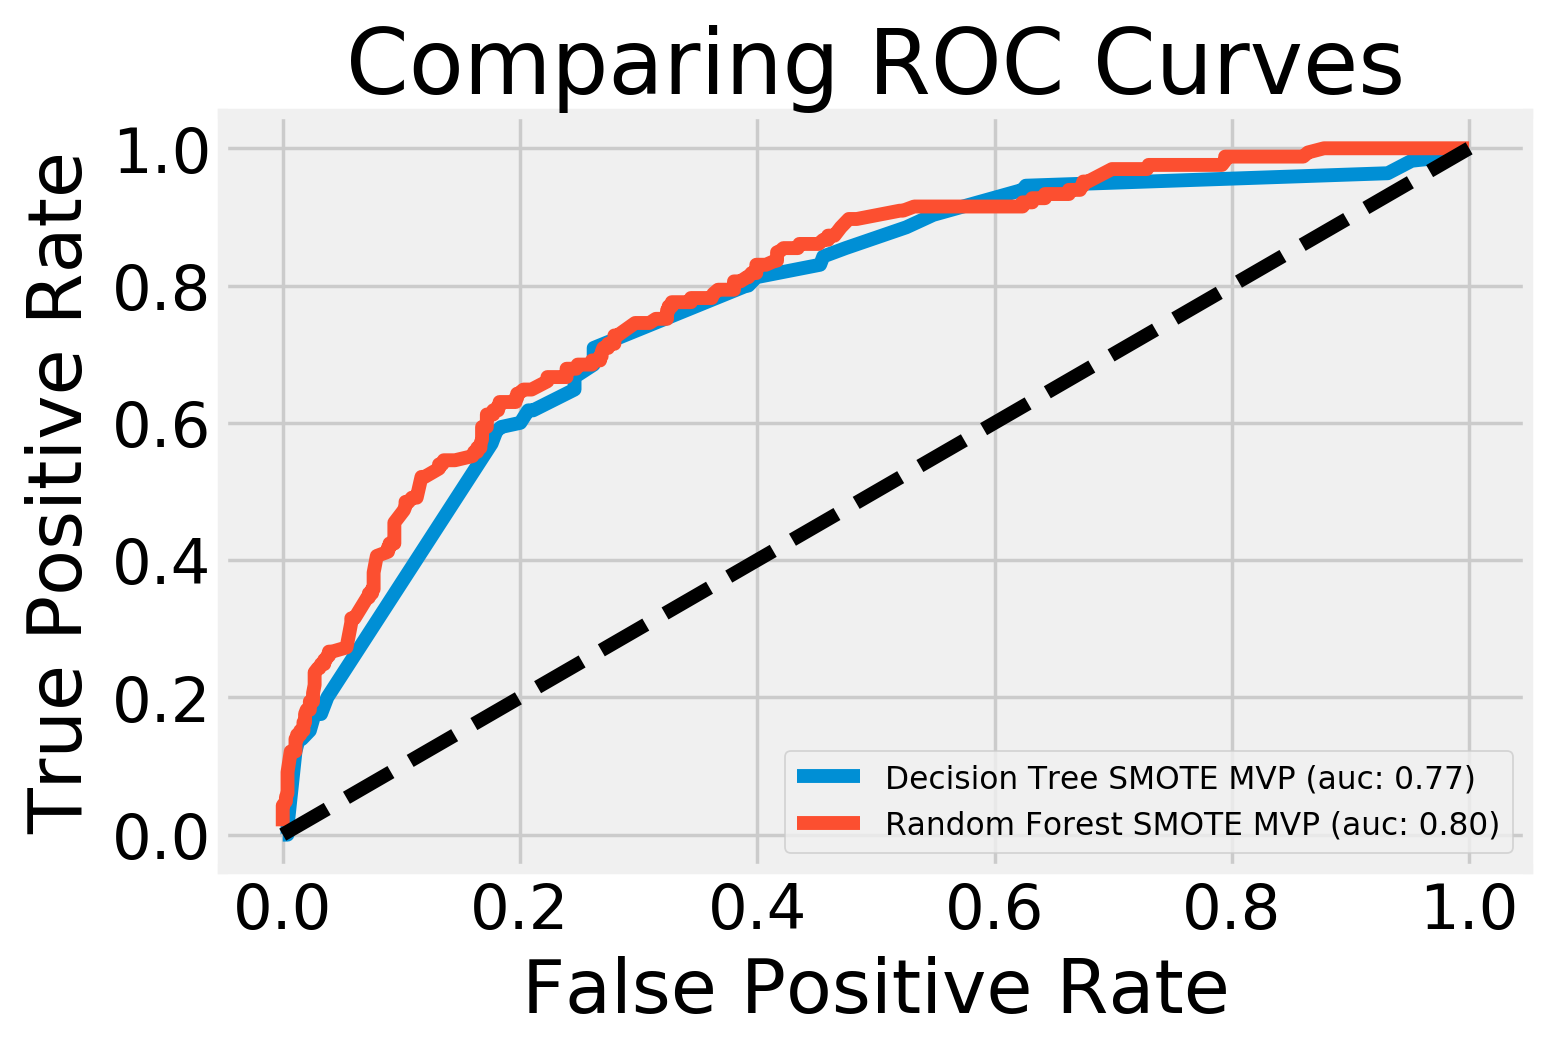

In [401]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REDO WITH LESS FEATURES

In [402]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [403]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 22 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Aircraft_Category_Airplane           2727 non-null uint8
Aircraft_Category_Balloon            2727 non-null uint8
Aircraft_Category_Glider             2727 non-null uint8
Aircraft_Category_Gyrocraft          2727 non-null uint8
Aircraft_Category_Helicopter         2727 non-null uint8
Flight_Purpose_Aerial Application    2727 non-null uint8
Flight_Purpose_Business              2727 non-null uint8
Flight_Purpose_Ferry                 2727 non-null uint8
Flight_Purpose_Instructional         2727 non-null uint8
Flight_Purpose_Other                 2727 non-null uint8
Flight_Purpose_Personal              2727 non-null uint8
Flight_Purpose_Positioning       

In [404]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI'])

y_smoted = pd.Series(y_smoted)

In [405]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- less features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- less features
LR accuracy: 0.5827 precision: 0.608 recall: 0.6453 f1: 0.5418 fB: 0.5812

Scores with SMOTE Oversampling -- less features
KNN accuracy: 0.6291 precision: 0.6441 recall: 0.5823 f1: 0.5569 fB: 0.561

Scores with SMOTE Oversampling -- less features
NB accuracy: 0.5943 precision: 0.7838 recall: 0.1285 f1: 0.215 fB: 0.1531

Scores with SMOTE Oversampling -- less features
SVC accuracy: 0.61 precision: 0.6253 recall: 0.623 f1: 0.5551 fB: 0.5779

Scores with SMOTE Oversampling -- less features
Decision Tree accuracy: 0.5997 precision: 0.6071 recall: 0.6808 f1: 0.5642 fB: 0.6095

Scores with SMOTE Oversampling -- less features
Random Forest accuracy: 0.5908 precision: 0.6087 recall: 0.6696 f1: 0.555 fB: 0.5993

Scores with SMOTE Oversampling -- less features
Gradient Boosted Trees accuracy: 0.5603 precision: 0.5994 recall: 0.6683 f1: 0.5327 fB: 0.5844



In [406]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7272523532048408, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
logistic: best score: 0.7642312864186463, best estimator: LogisticRegression(C=1.873817422860385, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.735992828328104, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7404751232631107, best

In [407]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.8327832783278328, best estimator: LogisticRegression(C=0.04328761281083059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [408]:
lm2 = grid.best_estimator_
lm2.fit(X_smoted, y_smoted)

LogisticRegression(C=0.04328761281083059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [409]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Less Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Less Features
Logistic Regress accuracy: 0.7555 precision: 0.6537 recall: 0.6802 f1: 0.6519 fB: 0.6645



In [410]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

coef_viewer = {}
for col, score in zip(columns, lm2.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane           0.067875
Aircraft_Category_Balloon            0.000000
Aircraft_Category_Glider             0.023008
Aircraft_Category_Gyrocraft          0.000000
Aircraft_Category_Helicopter         0.527617
Broad_Phase_of_Flight_INFLIGHT       0.062940
Broad_Phase_of_Flight_LANDING        1.632870
Broad_Phase_of_Flight_TAKEOFF        0.792045
Broad_Phase_of_Flight_TAXI           1.374932
Flight_Purpose_Aerial Application    0.631907
Flight_Purpose_Business              0.046953
Flight_Purpose_Ferry                 0.053727
Flight_Purpose_Instructional         0.822885
Flight_Purpose_Other                 0.308215
Flight_Purpose_Personal              0.057085
Flight_Purpose_Positioning           0.037533
Season_Fall                         -0.068147
Season_Spring                        0.023936
Season_Summer                        0.095193
Season_Winter                        0.028979
Weather_Condition_IMC                0.019813
Weather_Condition_VMC             

In [411]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = lm2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE Logistic Regression Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE Logistic Regression Less Features
accuracy: 0.7679 precision: 0.4094 recall: 0.6303 f1: 0.4964 fB: 0.5689



In [412]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7541461228148812, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [413]:
rf3 = grid.best_estimator_
rf3.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [414]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7647 precision: 0.6571 recall: 0.7342 f1: 0.6751 fB: 0.7039



In [415]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.033577
Aircraft_Category_Balloon            0.001175
Aircraft_Category_Glider             0.006503
Aircraft_Category_Gyrocraft          0.002201
Aircraft_Category_Helicopter         0.014989
Broad_Phase_of_Flight_INFLIGHT       0.196736
Broad_Phase_of_Flight_LANDING        0.184594
Broad_Phase_of_Flight_TAKEOFF        0.041309
Broad_Phase_of_Flight_TAXI           0.040295
Flight_Purpose_Aerial Application    0.030624
Flight_Purpose_Business              0.016970
Flight_Purpose_Ferry                 0.006354
Flight_Purpose_Instructional         0.047470
Flight_Purpose_Other                 0.022926
Flight_Purpose_Personal              0.078423
Flight_Purpose_Positioning           0.001282
Season_Fall                          0.010823
Season_Spring                        0.012063
Season_Summer                        0.019276
Season_Winter                        0.012372
Weather_Condition_IMC                0.114564
Weather_Condition_VMC             

In [416]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf3.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE RF Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE RF Less Features
accuracy: 0.7668 precision: 0.4126 recall: 0.6727 f1: 0.5115 fB: 0.5974



In [417]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7389063200358583, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [418]:
dt2 = grid.best_estimator_
dt2.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [419]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7483 precision: 0.6445 recall: 0.7244 f1: 0.6607 fB: 0.691



In [420]:
from sklearn.metrics import fbeta_score

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Less Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Less Features
Decision Tree SMOTE Less Features accuracy: 0.7525 precision: 0.3951 recall: 0.6848 f1: 0.5011 fB: 0.5973

FINAL TEST Scores Less Features
LR SMOTE Less Features accuracy: 0.7679 precision: 0.4094 recall: 0.6303 f1: 0.4964 fB: 0.5689

FINAL TEST Scores Less Features
Random Forest SMOTE Less Features accuracy: 0.7668 precision: 0.4126 recall: 0.6727 f1: 0.5115 fB: 0.5974



In [423]:
feature_selection(X_smoted, y_smoted, 15)

,Feature_Importance,RFE
0,Broad_Phase_of_Flight_INFLIGHT,Season_Summer
1,Broad_Phase_of_Flight_LANDING,Aircraft_Category_Balloon
2,Weather_Condition_IMC,Aircraft_Category_Glider
3,Flight_Purpose_Personal,Aircraft_Category_Helicopter
4,Weather_Condition_VMC,Flight_Purpose_Aerial Application
5,Aircraft_Category_Airplane,Flight_Purpose_Business
6,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Ferry
7,Flight_Purpose_Instructional,Flight_Purpose_Instructional
8,Broad_Phase_of_Flight_TAXI,Flight_Purpose_Other
9,Flight_Purpose_Other,Flight_Purpose_Personal


In [425]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.037020
Aircraft_Category_Balloon            0.001458
Aircraft_Category_Glider             0.004981
Aircraft_Category_Gyrocraft          0.001936
Aircraft_Category_Helicopter         0.016328
Broad_Phase_of_Flight_INFLIGHT       0.228498
Broad_Phase_of_Flight_LANDING        0.139825
Broad_Phase_of_Flight_TAKEOFF        0.042614
Broad_Phase_of_Flight_TAXI           0.037516
Flight_Purpose_Aerial Application    0.030730
Flight_Purpose_Business              0.017132
Flight_Purpose_Ferry                 0.007203
Flight_Purpose_Instructional         0.048792
Flight_Purpose_Other                 0.022965
Flight_Purpose_Personal              0.079940
Flight_Purpose_Positioning           0.001778
Season_Fall                          0.011826
Season_Spring                        0.012165
Season_Summer                        0.020149
Season_Winter                        0.011963
Weather_Condition_IMC                0.101159
Weather_Condition_VMC             

In [421]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.28120791 0.71879209]
 [0.65941838 0.34058162]
 [0.20917525 0.79082475]
 ...
 [0.6195594  0.3804406 ]
 [0.46567626 0.53432374]
 [0.34897415 0.65102585]]


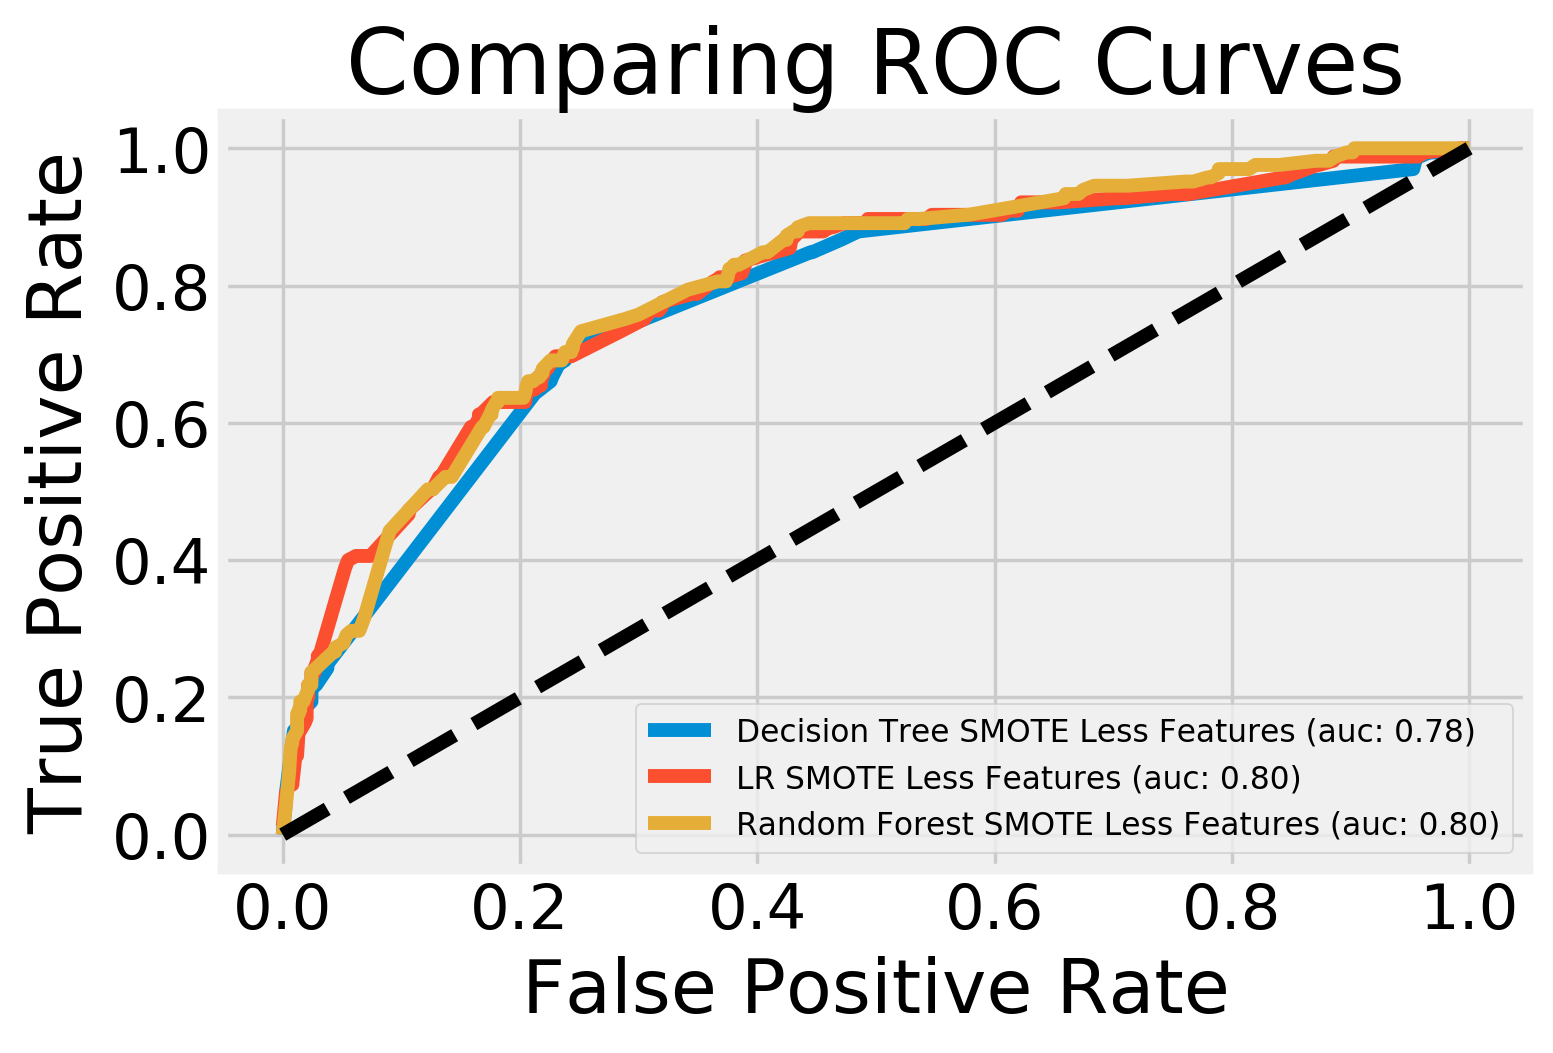

In [422]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REPEAT WITH EVEN LESS FEATURES

In [474]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [475]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 17 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Flight_Purpose_Aerial Application    2727 non-null uint8
Flight_Purpose_Business              2727 non-null uint8
Flight_Purpose_Ferry                 2727 non-null uint8
Flight_Purpose_Instructional         2727 non-null uint8
Flight_Purpose_Other                 2727 non-null uint8
Flight_Purpose_Personal              2727 non-null uint8
Flight_Purpose_Positioning           2727 non-null uint8
Weather_Condition_IMC                2727 non-null uint8
Weather_Condition_VMC                2727 non-null uint8
Broad_Phase_of_Flight_INFLIGHT       2727 non-null uint8
Broad_Phase_of_Flight_LANDING        2727 non-null uint8
Broad_Phase_of_Flight_TAKEOFF    

In [476]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted_last = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI'])

y_smoted_last = pd.Series(y_smoted)

In [477]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted_last):
        
        kX_train = X_smoted_last.iloc[train_index]
        kX_test = X_smoted_last.iloc[test_index]
        ky_train = y_smoted_last.iloc[train_index]
        ky_test = y_smoted_last.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- last features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- last features
LR accuracy: 0.5412 precision: 0.5997 recall: 0.65 f1: 0.5134 fB: 0.5636

Scores with SMOTE Oversampling -- last features
KNN accuracy: 0.5847 precision: 0.6244 recall: 0.5729 f1: 0.5202 fB: 0.5366

Scores with SMOTE Oversampling -- last features
NB accuracy: 0.5645 precision: 0.7801 recall: 0.0919 f1: 0.162 fB: 0.1111

Scores with SMOTE Oversampling -- last features
SVC accuracy: 0.5576 precision: 0.6101 recall: 0.6527 f1: 0.5274 fB: 0.5711

Scores with SMOTE Oversampling -- last features
Decision Tree accuracy: 0.5616 precision: 0.5969 recall: 0.6854 f1: 0.5399 fB: 0.5942

Scores with SMOTE Oversampling -- last features
Random Forest accuracy: 0.5453 precision: 0.5889 recall: 0.6847 f1: 0.5287 fB: 0.5865

Scores with SMOTE Oversampling -- last features
Gradient Boosted Trees accuracy: 0.5311 precision: 0.5905 recall: 0.662 f1: 0.5093 fB: 0.5672



In [478]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.709995517705065, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
logistic: best score: 0.7411474675033617, best estimator: LogisticRegression(C=533.6699231206312, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.735320484087853, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7357687135813537, best e

In [479]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.7411474675033617, best estimator: LogisticRegression(C=533.6699231206312, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [480]:
lm3 = grid.best_estimator_
lm3.fit(X_smoted_last, y_smoted_last)

LogisticRegression(C=533.6699231206312, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [481]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Last Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Last Features
Logistic Regress accuracy: 0.7443 precision: 0.6436 recall: 0.7125 f1: 0.6548 fB: 0.6818



In [482]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

coef_viewer = {}
for col, score in zip(columns, lm3.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Broad_Phase_of_Flight_INFLIGHT       4.247334
Broad_Phase_of_Flight_LANDING        6.255122
Broad_Phase_of_Flight_TAKEOFF        5.405968
Broad_Phase_of_Flight_TAXI           7.393039
Flight_Purpose_Aerial Application    5.331962
Flight_Purpose_Business              4.106579
Flight_Purpose_Ferry                 5.019744
Flight_Purpose_Instructional         5.093192
Flight_Purpose_Other                 4.485528
Flight_Purpose_Personal              3.822201
Flight_Purpose_Positioning           4.372815
Season_Fall                          0.203233
Season_Spring                        0.464462
Season_Summer                        0.506730
Season_Winter                        0.345887
Weather_Condition_IMC               -1.209407
Weather_Condition_VMC                0.268712
dtype: float64

In [483]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7391304347826086, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [484]:
rf4 = grid.best_estimator_
rf4.fit(X_smoted_last, y_smoted_last)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [485]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf4.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7479 precision: 0.6418 recall: 0.7365 f1: 0.663 fB: 0.6981



In [486]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI']

feature_viewer = {}
for col, score in zip(columns, rf4.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.247264
Broad_Phase_of_Flight_LANDING        0.147506
Broad_Phase_of_Flight_TAKEOFF        0.059230
Broad_Phase_of_Flight_TAXI           0.046031
Flight_Purpose_Aerial Application    0.026576
Flight_Purpose_Business              0.019073
Flight_Purpose_Ferry                 0.003991
Flight_Purpose_Instructional         0.045346
Flight_Purpose_Other                 0.024663
Flight_Purpose_Personal              0.072853
Flight_Purpose_Positioning           0.002055
Season_Fall                          0.015779
Season_Spring                        0.016741
Season_Summer                        0.020960
Season_Winter                        0.019992
Weather_Condition_IMC                0.129066
Weather_Condition_VMC                0.102873
dtype: float64

In [487]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.735320484087853, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [488]:
dt3 = grid.best_estimator_
dt3.fit(X_smoted_last, y_smoted_last)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [489]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7344 precision: 0.6319 recall: 0.7258 f1: 0.6507 fB: 0.686



In [490]:
predict_y_smoted_last = rf4.predict(X_smoted_last)

In [491]:
import collections

collections.Counter(predict_y_smoted_last)

Counter({'Fatal': 2290, 'Non-fatal': 2172})

In [492]:
collections.Counter(y_smoted_last)

Counter({'Fatal': 2231, 'Non-fatal': 2231})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.832


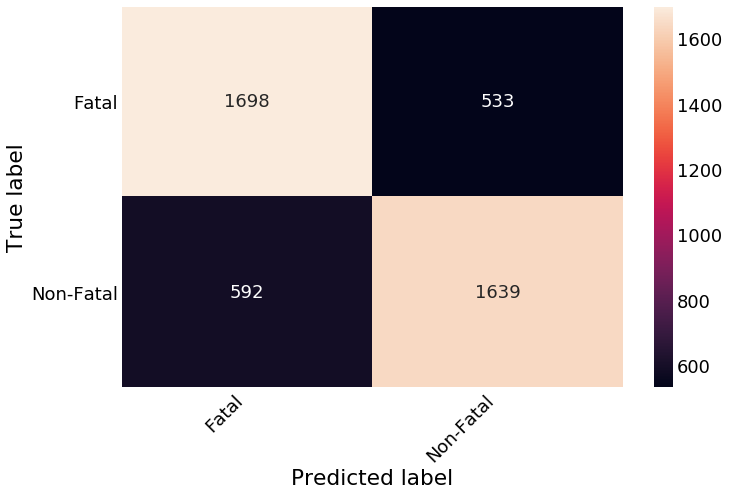

In [503]:
#Checking accuracy score on smoted model
from sklearn.metrics import confusion_matrix

RF_cross_val = cross_val_score(rf4, X_train, y_train, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_smoted_last, predict_y_smoted_last)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [494]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Last Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Last Features
Decision Tree SMOTE Last Features accuracy: 0.7382 precision: 0.3795 recall: 0.697 f1: 0.4915 fB: 0.5971

FINAL TEST Scores Last Features
LR SMOTE Last Features accuracy: 0.7624 precision: 0.4079 recall: 0.6848 f1: 0.5113 fB: 0.603

FINAL TEST Scores Last Features
Random Forest SMOTE Last Features accuracy: 0.7514 precision: 0.3952 recall: 0.697 f1: 0.5044 fB: 0.6046



In [495]:
feature_selection(X_smoted_last, y_smoted_last, 15)

,Feature_Importance,RFE
0,Weather_Condition_IMC,Season_Spring
1,Broad_Phase_of_Flight_LANDING,Season_Summer
2,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Aerial Application
3,Flight_Purpose_Personal,Flight_Purpose_Business
4,Broad_Phase_of_Flight_TAXI,Flight_Purpose_Ferry
5,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Instructional
6,Flight_Purpose_Instructional,Flight_Purpose_Other
7,Flight_Purpose_Other,Flight_Purpose_Personal
8,Flight_Purpose_Business,Flight_Purpose_Positioning
9,Season_Summer,Weather_Condition_IMC


In [496]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted_last, y_smoted_last)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.24411923 0.75588077]
 [0.67343569 0.32656431]
 [0.30641187 0.69358813]
 ...
 [0.60264619 0.39735381]
 [0.44817102 0.55182898]
 [0.32979161 0.67020839]]


Text(0.5,1,'Comparing ROC Curves')

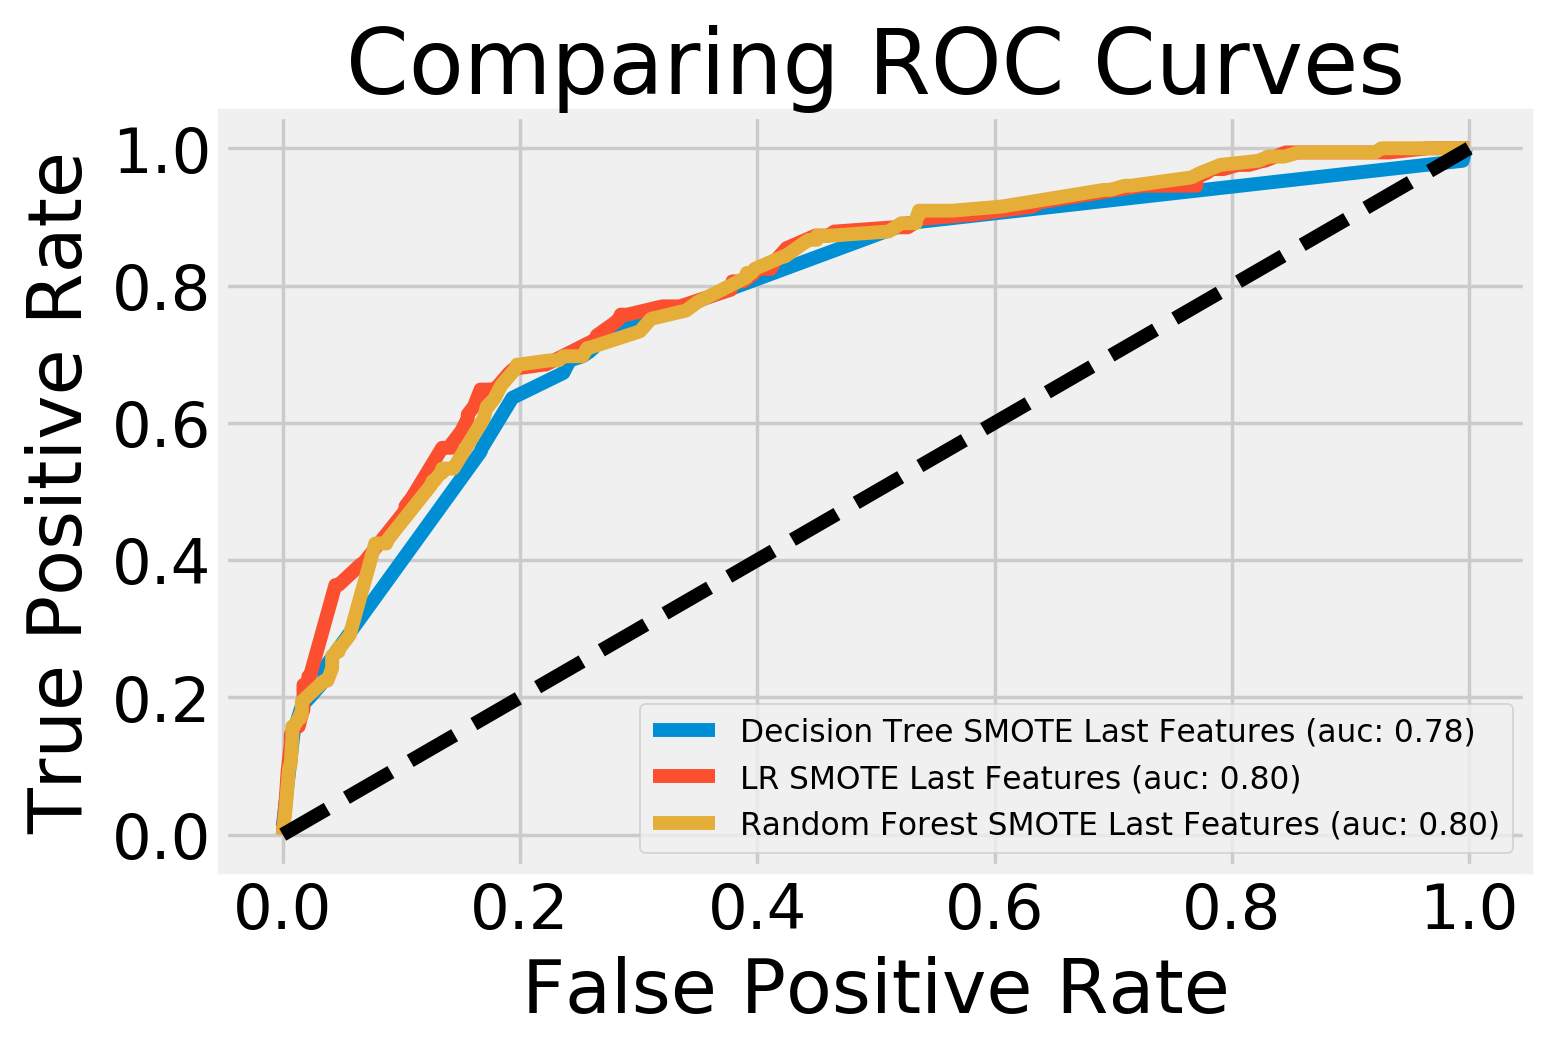

In [497]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [498]:
predict_y_FINALtest = rf4.predict(X_FINALtest)

In [499]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 282, 'Non-fatal': 627})

In [500]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 744})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.839


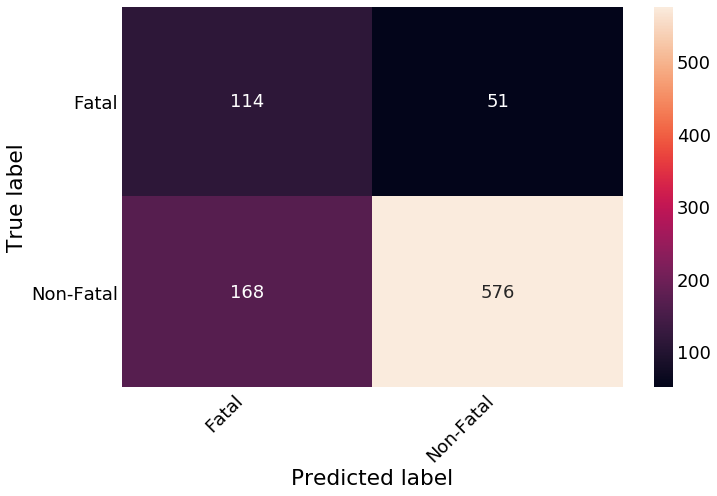

In [502]:
#Checking final accuracy of model

RF_cross_val = cross_val_score(rf4, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])